# Lecture 5: Model Evaluation, Cross-validation (CV) & Grid Search CV

* How to use cross-validation (CV)
* How to use grid search CV

## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

## Data

We generate random data of the form $Y=10 - \frac{1}{X + 0.1} + \epsilon$ (code from the [book](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn)):

In [2]:
rng = np.random.RandomState(10)
# feature matrix
X = rng.rand(100, 1) ** 2
# data generating process
y = 10 - 1. / (X.ravel() + 0.1)
# noise
y += 1.0 * rng.randn(100)

The random data looks like this:

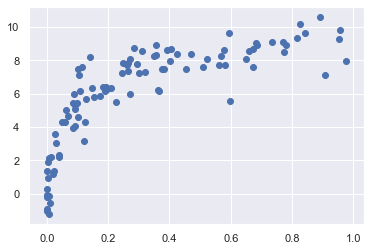

In [3]:
plt.scatter(X, y);

We split our data into training and test sets:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=284639,
                                                    train_size=0.7)

print(f'   Train  Test   Total')
print(f'X: {X_train.shape[0]}   + {X_test.shape[0]}   = {X.shape[0]}')
print(f'y: {y_train.shape[0]}   + {y_test.shape[0]}   = {y.shape[0]}')

   Train  Test   Total
X: 70   + 30   = 100
y: 70   + 30   = 100


## Cross-validation (CV)

Let's begin by fitting a [1st-degree polynomial model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression):

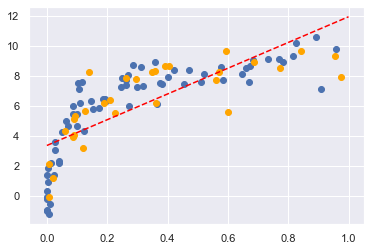

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# create model pipeline
model = make_pipeline(PolynomialFeatures(1),
                      LinearRegression(fit_intercept=True))

# transform variables and fit model on training data
model.fit(X_train, y_train)

# plot training data
plt.scatter(X_train, y_train)

# plot regerssion line
y_fit = model.predict(np.array([0,1])[:, np.newaxis])
plt.plot(np.array([0,1])[:, np.newaxis],
         y_fit,
         color='red', linestyle='--');

# plot test data
plt.scatter(X_test, y_test, color='orange');

The model's $R^2$ in the test data ...

In [6]:
model.score(X_test, y_test)

0.4931005822067103

... and in the training data:

In [7]:
model.score(X_train, y_train)

0.5968582838480656

The usual picture: the model fits the training data much better than the test data.

Let's explore what happens when we apply **5-fold cross-validation** (**5-CV**) to the training data. We can use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score) for this. It takes at least three parameters:
* `estimator`: the model we want to validate
* `X`: the $X$'s on which we want to validate the model (usually the training data)
* `y`: the corresponding $y$'s
* `cv`: optional, the number of folds; default = 5

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.59675577, 0.37970477, 0.69134131, 0.4571663 , 0.59939331])

We opted for 5 folds, so we get 5 scores back. If we don't specify which scoring metric to use, `cross_val_score()` uses `model.score()` by default. For `LinearRegression`, that's of course $R^2$.

The important observation is that the *mean* of the 5-fold CV scores is closer to the test score (which was $\approx0.49$):

In [9]:
scores.mean()

0.5448722918029787

Bear in mind that this is the *training data*, in which the model per se performs much better ($\approx0.59$). Thus, without sacrificing valuable training data, cross-validation allows us to test our model hyperparameters almost as well as if we had another validation data set.

`cross_val_score()` only allows one scoring metric, but if you want to use more than one, you can use [`sklearn.model_selection.cross_validate()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).

The next step is to use grid search with CV to test several hyperparameters and find those that fit our data best:

## Grid Search CV

We begin by importing [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which is the class that performs grid search. We then define the *parameter space* that `GridSearchCV` should cover. We do this with a simple dictionary, in which the keys are the parameters and the values are the variations of these parameters that we want to check.

In our case we use a pipeline (`make_pipeline()`), so we need to specify to which part of the pipeline each parameter belongs. We do this by first stating the step's names (e.g., `polynomialfeatures` and `linearregression`), followed by two underscores (`__`), and then the parameter names (e.g., `degree`).

We also set `cv=5` to get 5-fold CV.

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(make_pipeline(PolynomialFeatures(),
                                  LinearRegression()),
                    param_grid, cv=5)

After this setup, we "fit" the `GridSearchCV`, which means that now each potential model combination is fit and 5-fold cross-validated. Note that we're now testing $21 × 2 × 2=84$ parameter combinations!

In [11]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearre

All results of the grid search are stored in `grid.cv_results_`:

In [12]:
grid.cv_results_

{'mean_fit_time': array([0.        , 0.0031353 , 0.00312924, 0.        , 0.        ,
        0.        , 0.00312109, 0.        , 0.00311818, 0.        ,
        0.00312476, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00312376, 0.        , 0.        ,
        0.        , 0.        , 0.00040669, 0.00202112, 0.00040951,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00161581, 0.        , 0.        ,
        0.00161853, 0.        , 0.0016109 , 0.00040293, 0.        ,
        0.00200467, 0.        , 0.00202208, 0.        , 0.        ,
        0.00040984, 0.00040464, 0.        , 0.00040975, 0.        ,
        0.        , 0.00041261, 0.        , 0.        , 0.00161209,
        0.00161004, 0.        , 0.00042057, 0.00040956, 0.        ,
        0.00161142, 0.        ,

It's a lot of data on each model combination, but what we're really interested in is the best model. We can access this in two ways:
1. `grid.best_params_`: the parameters to create the best model

In [13]:
grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': False,
 'polynomialfeatures__degree': 5}

`fit_intercept` is `False`, so `normalize` shouldn't matter
    
2. `grid.best_estimator_`: the fully fit best model, which we can use directly in predictions

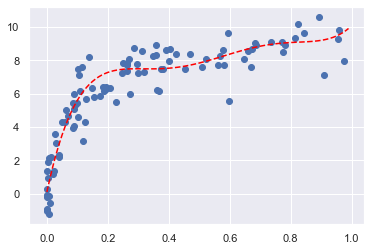

In [14]:
model = grid.best_estimator_

plt.scatter(X, y)
y_fit = model.predict(np.arange(0, 1, .01)[:, np.newaxis])
plt.plot(np.arange(0, 1, .01), y_fit, color='red', linestyle='--');

We can get the best model's score with:

In [15]:
grid.best_score_

0.8891561231283086

The last step is to check the test score:

In [16]:
model.score(X_test, y_test)

0.778005816570997

I used a couple of NumPy functions to generate random data and to plot regression lines, such as [`np.arange()`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html). Feel free to check them out if you're interested, but they won't be part of any assignment.

© 2023 Philipp Cornelius